<a href="https://colab.research.google.com/github/5harad/DPI-617/blob/main/labs/reasonable-suspicion-answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Law, Order, and Algorithms**
## A statistical approach to assessing _reasonable suspicion_

**Getting started**

Before you start, create a copy of this Jupyter notebook in your own Google Drive by clicking `Copy to Drive` in the menubar. If you do not do this your work will not be saved! 

Remember to save your work frequently by pressing command-S or clicking File > Save in the menubar. 

We recommend completing this problem set in Google Chrome.

**Installing libraries**

As before, we'll start by loading the libraries that we'll use in this lab. But this time we'll need to install the `pROC` library first, which lets us compute error rates in predictive models. 

Run the cell below to install and load the libraries. It may take a minute or two to complete.

In [1]:
# install the library pROC, which lets us compute error rates
install.packages('pROC')

# load libraries
library(tidyverse)
library(scales)
library(pROC)

# Set some formatting options
options(digits = 3, repr.matrix.max.rows = 10, repr.matrix.max.cols = 100)
theme_set(theme_bw())

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




## Background

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband.

In New York City, between 2003 and 2013, over 100,000 stops were recorded per year, with 685,724 stops recorded in a single year at the height of the practice in 2011. You can read more about this [here](https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City).

The vast majority of those stopped were African-American or Hispanic, raising concerns of racial bias. Further, there's concern that many stops were conducted without "reasonable suspicion" of criminal activity, in violation of the Fourth Amendment. 

In this lab, we will work with a sample of stops in NYC made between 2007 and 2013, recorded on a [UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/), to explore a statistical approach to assessing potential Fourth Amendment violations outlined in the paper [Precinct or Prejudice? Understanding Racial Disparities in New York City's Stop-and-Frisk Policy](https://5harad.com/papers/stop-and-frisk.pdf) by Goel, Rao, and Shroff.

## The data

This week, we will use the same data that we used a couple of weeks ago: a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link].

Run the cell below to load the data. For simplicity, we'll work with a subset of the columns, and we'll limit to stops where there is no missing information (i.e., every variable has a value).

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf
      

In [2]:
# Load data
fname <- "https://github.com/5harad/DPI-617/blob/main/data/sqf_sample.rds?raw=true"
stop_df <- readRDS(url(fname))

# Select the columns we'll use in the lab today, and exclude missing observations
stop_df <- stop_df %>%
  select('found_weapon', 'frisked', 'suspected_crime', 'precinct',
         'month', 'day', 'year',
         'inside_outside', 'location_housing',
         'radio_run', 'officer_uniform', 'observation_period',
         starts_with('subject_'), -subject_hispanic, -subject_dob,
         starts_with('stopped_bc_'),
         starts_with('additional_')) %>%
  na.omit()

stop_df

found_weapon,frisked,suspected_crime,precinct,month,day,year,inside_outside,location_housing,radio_run,officer_uniform,observation_period,subject_sex,subject_race,subject_age,subject_height,subject_weight,subject_hair,subject_eye,subject_build,stopped_bc_object,stopped_bc_desc,stopped_bc_casing,stopped_bc_lookout,stopped_bc_clothing,stopped_bc_drugs,stopped_bc_furtive,stopped_bc_violent,stopped_bc_bulge,stopped_bc_other,additional_report,additional_investigation,additional_proximity,additional_evasive,additional_associating,additional_direction,additional_highcrime,additional_time,additional_sights,additional_other
<lgl>,<lgl>,<chr>,<fct>,<ord>,<ord>,<int>,<lgl>,<fct>,<lgl>,<lgl>,<dbl>,<fct>,<fct>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
FALSE,TRUE,robbery,105,March,Sunday,2008,FALSE,neither,FALSE,FALSE,1,male,black,23,5.92,185,black,brown,thin,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE
FALSE,TRUE,cpw,113,January,Thursday,2011,FALSE,neither,FALSE,FALSE,1,male,black,30,5.83,180,black,brown,medium,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,TRUE,cpw,47,March,Tuesday,2013,FALSE,neither,FALSE,FALSE,1,male,black,35,5.42,160,black,black,medium,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
FALSE,FALSE,criminal possession of marihuana,23,August,Friday,2011,FALSE,housing,TRUE,TRUE,2,male,hispanic,28,5.67,170,dyed,brown,medium,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
FALSE,FALSE,grand larceny auto,83,May,Saturday,2007,FALSE,neither,FALSE,TRUE,1,male,hispanic,27,5.75,140,black,brown,thin,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,TRUE,cpw,23,February,Saturday,2009,FALSE,neither,FALSE,FALSE,5,male,hispanic,26,5.42,190,brown,brown,medium,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
FALSE,FALSE,cpw,75,April,Friday,2007,FALSE,housing,FALSE,TRUE,2,male,black,39,5.67,165,black,brown,medium,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
FALSE,TRUE,robbery,75,December,Thursday,2011,FALSE,neither,FALSE,FALSE,3,male,black,17,6.00,170,brown,brown,thin,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


## Analysis

For this lab, we will focus on stops for suspicion of criminal possession of a weapon (CPW).

###Exercise: Data filtering

In [3]:
# Your code here!
# Create a data frame named stops_cpw with only cpw stops,
# as indicated by column suspected_crime
# START solution

stops_cpw <- stop_df %>%
  filter(suspected_crime == "cpw")

# END solution

One might say that a CPW stop was _ex post_ justified if a weapon was ultimately recovered. To gauge whether such a stop was _ex ante_ justified, we will use the available data to build a risk assessment model, allowing us to estimate the likelihood a stopped individual is carrying a weapon. We can then examine the model-estimated risk scores to see whether people were stopped even though the available evidence suggests that they are unlikely to be carrying a weapon, potentially in violation of the Fourth Amendment. We will look at each of these steps — estimating risk and examining scores — in turn below.

### Estimating risk

For an individual $i$, let $X_i$ be all the information we know about the
individual prior to making the stop decision, and define


$$
Y_i =
\begin{cases}
1 & \textrm{if a weapon is found on individual } i \\
0 & \textrm{otherwise}
\end{cases}
$$


Then, the _risk_ we are interested in measuring can be written as

$$
r_i = \Pr(Y_i = 1 ~|~ X_i).
$$



In other words, we wish to estimate the probability that we will recover a 
weapon from an individual, characterized by covariates $X_i$, if we were to 
stop (and frisk) them.

One way to estimate this probability is to fit a logistic regression on the
subset of individuals who were stopped, to predict whether a weapon will be
found, using all the covariates that an officer observed prior to conducting the
stop. 

Don't worry if you haven't heard of logistic regression before! We'll talk about
it more in later lectures; for now, we'll treat logistic regression as a black-box
that spits out an estimated probability of finding a weapon on someone matching
a certain set of criteria (or _features_) that we specify.

To fit and evaluate our risk model, we split the data into two parts: a _training_ set and a _test_ set.
We fit (or _train_) our logistic regression model using the training set, and then use the fitted model to generate predictions on the test set. This splitting of the data helps to ensure that the model isn't able to "cheat" when making its predictions.

In [4]:
# Split train-test set
stops_train_cpw <- stops_cpw %>%
  filter(year %in% 2009:2010)

stops_test_cpw <- stops_cpw %>%
  filter(year %in% 2011:2012)

We'll start be estimating risk based on whether the officer reported seeing a "bulge" (indicative of carrying a weapon) and whether the officer indicated that the stop occurred in a "high-crime" neighborhood. We train and make predictions with the logistic regression model as follows:

In [5]:
# We start by specifying which risk factors to include in the model
features <- c('stopped_bc_bulge', 'additional_highcrime')

# We will use all covariates listed in "features" to predict the outcome "found_weapon"
glm_formula <- reformulate(features, response="found_weapon")
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial())

Using the model we trained above, we'll make predictions on the test.

At the end of this process, we get a vector of predictions that indicates how likely each person in the test set is to be carrying a weapon, based on the two specified risk factors.

In [6]:
# Make predictions on the test set
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

In [7]:
head(predictions)

1      2      3      4      5      6 
0.0360 0.0232 0.0360 0.0232 0.0616 0.0400

To see where these predictions are coming from, we can check how much weight the model is putting on each of the factors, displayed in the `estimate` column in the table below. Based on the historical data, the model believes that people stopped because of a reported "bulge" are at higher risk of carrying a weapon (since the estimate is positive). Further, people stopped because they are in a "high crime" neighborhood are at _lower_ risk of carrying a weapon, compared to those without this factor reported as a basis for the stop (since the estimate is negative).

In [8]:
summary(glm_fit)


Call:
glm(formula = glm_formula, family = binomial(), data = stops_train_cpw)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.357  -0.286  -0.271  -0.217   2.744  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -3.2870     0.0287  -114.5   <2e-16 ***
stopped_bc_bulgeTRUE       0.5637     0.0376    15.0   <2e-16 ***
additional_highcrimeTRUE  -0.4541     0.0372   -12.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 26448  on 87045  degrees of freedom
Residual deviance: 26103  on 87043  degrees of freedom
AIC: 26109

Number of Fisher Scoring iterations: 6


### Exercise: Model interpretation
Why do you think the "high crime" rationale is associated with _lower_ risk of carrying a weapon in the model above?

Now we'll quantify how well this risk model performs.
There are many ways to evaluate a model's performance.
For a binary classification task like the one we are working on (predicting whether or not someone is carrying a weapon), a common performance metric is [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Given a random pair of people in the dataset, exactly one of whom is carrying a weapon, the AUC is the probability that the model will correctly identify the person with the weapon. A perfect binary prediction model will thus give an AUC of 1 while a model that is making random guesses will produce an AUC of 0.5.

To compute the AUC, we'll use the `auc` function (from the `pROC` library that we installed earlier). The `auc` function requires two inputs: (1) the true outcomes (i.e., whether or not someone was carrying a weapon; and (2) the predictions.

The true outcomes (i.e., whether someone was carrying a weapon) is stored in the `found_weapon` column of the `stops_test_cpw` data frame. To pull out the `found_weapon` column as a stand-alone vector, we use the `$` operator.

In [9]:
stops_test_cpw$found_weapon

[1] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [25] FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
   [37] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
   [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [97] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [157] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE
  [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE
  [205] FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [241] FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [253] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE
  [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [301]  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [313] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [349] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [397] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE
  [409] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
  [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [481] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE
  [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [505] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE
  [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [577] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [6

Now we can compute the AUC by providing the `auc` function the vector of true outcomes and the vector of predictions.

In [10]:
auc(stops_test_cpw$found_weapon, predictions)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



Area under the curve: 0.608

### Exercise: Interpreting model fit
Discuss the AUC of the risk model above. How well would you say the model is doing?

### Exercise: Building a better predictive model

In the above model, we used `stopped_bc_bulge` and `additional_highcrime` as the only risk factors used to predict whether an individual has a weapon. Explore incorporating additional factors from the dataset to build a more accurate model. To do this, start with the model-building code above, and then add additional factors to the `features` vector.

In [11]:
# Your code here!
# Build a better model by including more features
# START solution
features <- c('precinct', 'inside_outside', 'location_housing',
              'subject_build', 'subject_height', 'subject_weight', 
              'subject_age', 'observation_period', 
              'month', 'day',
              'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 
              'stopped_bc_drugs', 'stopped_bc_violent', 'stopped_bc_lookout', 
              'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 
              'stopped_bc_desc',
              'additional_highcrime', 'additional_investigation', 
              'additional_proximity', 'additional_direction', 'additional_other',
              'additional_associating', 'additional_sights', 'additional_time', 
              'additional_evasive', 'additional_report',
              'radio_run', 'officer_uniform')

# train the model
glm_formula <- reformulate(features, response="found_weapon")
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial())

# generate predictions
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")
# END solution

You can run the code below to compute the AUC of your new predictions

In [12]:
auc(stops_test_cpw$found_weapon, predictions)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



Area under the curve: 0.822

### Exercise: Interpreting risk scores

Discuss your risk model. 
Do you think it gives an accurate estimate of the likelihood someone has a weapon, 
based on information observed by the officer?

### Assessing 4A violations

We'll now use our model estimates to assess potential Fourth Amendment violations. To start, we'll compute the fraction of CPW stops that have less than 1% _ex ante_ chance of recovering a weapon.


### Exercise: Calculate the proportion of stops that have low probability of "success".

Step 1. Starting with your `predictions`, create a binary vector (with `TRUE` and `FALSE` values) that indicates whether each stop had less than a 1% _ex ante_ chance of recovering a weapon.

Step 2. With this binary vector, compute the proportion of values that are `TRUE`. You can use the `length` function to compute the length of a vector (i.e, the number of entries in it).

Once you compute the fraction of stops that have low likelihood of recovering a weapon, discuss the result. Do you think this provides evidence of Fourth Amendment violations?

In [13]:
# Your code here!
# START solution
is_low_risk <- (predictions < 0.01)
sum(is_low_risk) / length(predictions)

# We can also do this in one fell swoop by taking the mean!
mean(predictions < 0.01)
# END solution

[1] 0.317

[1] 0.317

Now we'll repeat this exercise for every threshold (e.g., 0.1% and 2%). 
(This is called the [cumulative distirbution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the risk distribution.)

Warning message:
“Removed 4000 rows containing non-finite values (`stat_ecdf()`).”


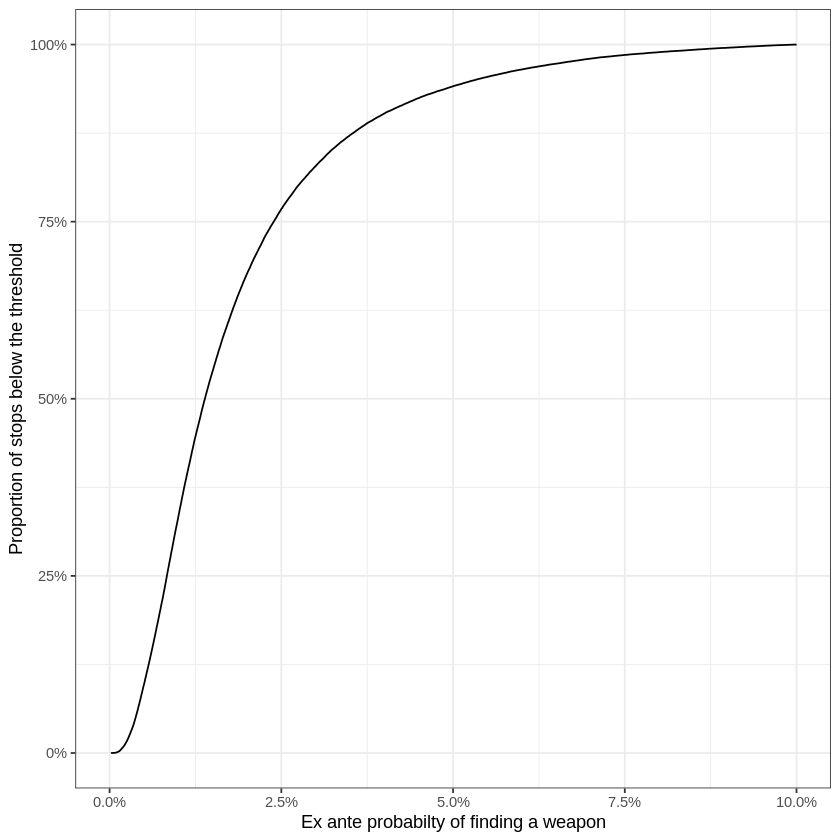

In [14]:
stops_test_cpw %>%
  mutate(found_weapon_p = predictions) %>%
  ggplot(aes(found_weapon_p)) + 
  stat_ecdf(pad=FALSE) +
  scale_x_continuous(
    'Ex ante probabilty of finding a weapon', 
    limits = c(0,0.1),
    labels=percent_format()) +
  scale_y_continuous(
    'Proportion of stops below the threshold', 
    limits = c(0,1),
    labels=percent_format()
  )


### Exercise: Interpreting the result

Discuss the result above. What do you think the plot above tells us about Fourth Amendment violations?

Now let's generate a version of the plot above disaggregated by race, for those categorized in the dataset as `Black`, `Hispanic`, or `white`.

Warning message:
“Removed 3815 rows containing non-finite values (`stat_ecdf()`).”


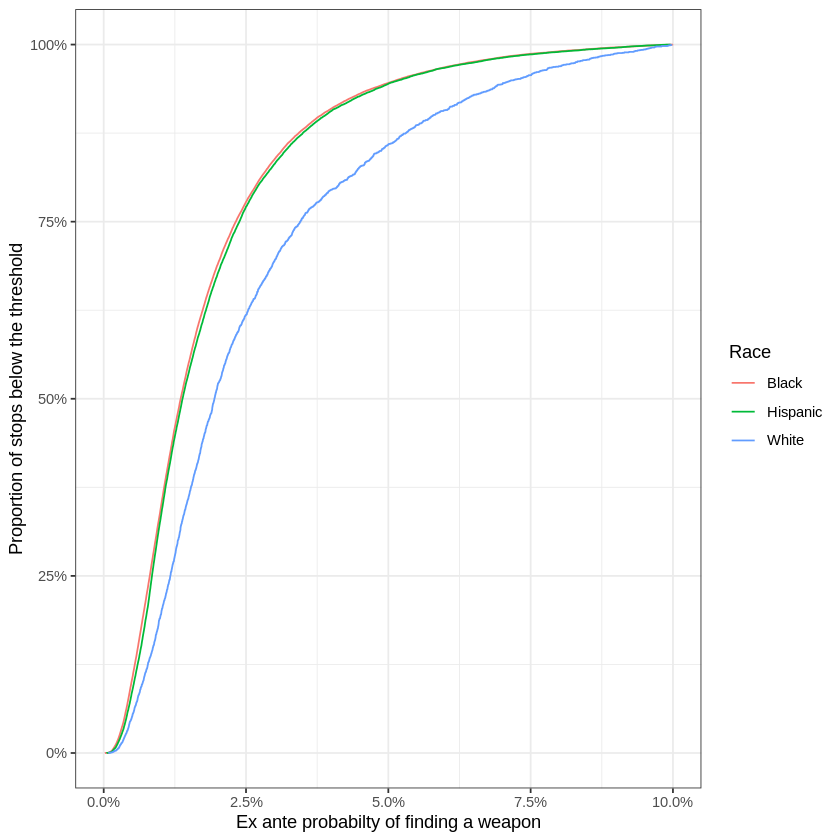

In [15]:
stops_test_cpw %>%
  mutate(found_weapon_p = predictions, 
         subject_race = str_to_title(subject_race)) %>%
  filter(subject_race %in% c('White','Black','Hispanic')) %>%
  ggplot(aes(found_weapon_p, color=subject_race)) + 
  stat_ecdf(pad=FALSE) +
  scale_x_continuous(
    'Ex ante probabilty of finding a weapon', 
    limits = c(0,0.1),
    labels=percent_format()) +
  scale_y_continuous(
    'Proportion of stops below the threshold', 
    limits = c(0,1),
    labels=percent_format()
  ) + 
  guides(color=guide_legend(title="Race"))


### Exercise: Interpreting the result

Discuss the result above. What do you think the plot above tells us about Fourth Amendment violations? What does it tell us about discrimination?